In [1]:
import pandas as pd
import datetime
import numpy as np
import altair as alt
#import matplotlib.pyplot as plt
#import seaborn as sns
#import japanize_matplotlib
#!pip install japanize_matplotlib

### マスタ確認とデータ整形

In [3]:
# マスタ修正の必要性を確認
rawData = 'AddDis調製データ.xlsx'
mst = 'C:\\Users\\hmill\\OneDrive\\デスクトップ\\sample_data\\データの可視化\\化療調製_AddDisデータ分析\\mst_data.xlsx'
df = pd.read_excel(rawData)
krebs = pd.read_excel(mst, sheet_name='krebs')
krebs_cds = krebs['薬品コード'].to_list()
ex = pd.read_excel(mst, sheet_name='exclusion')
exclusion = ex['薬品コード'].to_list()
ph = pd.read_excel(mst, sheet_name='ph')
ph_dict = {}
for i in range(len(ph)):
    key = ph.iloc[i, 0]
    value = ph.iloc[i, 1]
    ph_dict[f'{key}'] = value
ph_list = ph['調製者'].to_list()

df_check = df[['薬品コード', '薬品名', '調製者']]
df_drugs = df_check.query('薬品コード not in @krebs_cds')
df_drugs = df_drugs.query('薬品コード not in @exclusion')

if len(df_drugs) == 0:
  print('薬品マスタ（krebs・除外）の修正は不要です')
else:
  df_drugs.to_excel('mstメンテナンス\\薬品マスタ追加リスト.xlsx', index=False)
  print('薬品マスタ（krebs・除外）への追加リストを出力しました')

df_ph = df_check.query('調製者 not in @ph_list')
if len(df_ph) == 0:
  print('薬剤師マスタの修正は不要です')
else:
  df_ph.to_excel(f'mstメンテナンス\\薬剤師マスタ追加リスト.xlsx', index=False)
  print('薬剤師マスタへの追加リストを出力しました')

薬品マスタ（krebs・除外）の修正は不要です
薬剤師マスタの修正は不要です


In [4]:
# str日付をdatetimeに変換
df['実施日'] = pd.to_datetime(df['実施日'])
for i in range(len(df)):
    dt = df.loc[i, '実施日']
    h1, m1, s1 = df.loc[i, '調製開始'].split(':')
    df.loc[i, '調製開始'] = dt + datetime.timedelta(hours=int(h1), minutes=int(m1), seconds=int(s1))
    h2, m2, s2 = df.loc[i, '調製時間'].split(':')
    df.loc[i, '調製時間'] = dt + datetime.timedelta(minutes=int(m2), seconds=int(s2))

# 不要な行・列を削除  
df1 = df.query('薬品コード != @exclusion')
df1 = df1[['実施日', '入外', '科名', '病棟', 'オーダー番号', '調製者', '薬品本数', '薬品コード', '薬品名', '調製開始', '調製時間', '保留時間',]]
df1.sort_values('オーダー番号', ascending=True, inplace=True)

#オーダ番号がないレコードは削除
df1.dropna(subset='オーダー番号', inplace=True)
df1 = pd.merge(df1, krebs, how='inner')

# オーダー番号と用量（合計）の紐づけ
df1['mg'] = df1['薬品本数'] * df1['contain']

dose = df1.pivot_table(index='オーダー番号', values='mg', aggfunc='sum')
dose.reset_index(inplace=True)

# 調製時間の算出
prep_times = []
for i in range(len(df1)):
    tdelta = df1.loc[i, '調製時間'] - df1.loc[i, '実施日']
    sec = tdelta.total_seconds()  #秒に換算
    prep_times.append(sec/60)
df1['prep_time'] = prep_times
df = df1[['実施日', '入外', '科名', '病棟', 'オーダー番号', '薬品本数', '薬品コード', '薬品名', '調製開始', 'stem', 'contain', 'prep_time', 
          '調製者'
          ]]
df.sort_values('オーダー番号', ascending=False, inplace=True)  #同オーダー番号の最大値を採用
df.drop_duplicates(subset='オーダー番号', keep='first', inplace=True)
df = pd.merge(df, dose, how='outer')

hours = []
for i in range(len(df)):
  hour = df.loc[i, '調製開始'].strftime('%H時')
  hours.append(hour)
df['hour'] = hours

wd = []
for i in range(len(df)):
  weekday = df.loc[i, '実施日'].strftime('%a')
  wd.append(weekday)
df['wd'] = wd

for i in range(len(df)):
  key = df.loc[i, '調製者']
  df.loc[i, '調製者'] = ph_dict[key]

C:\Users\hmill\AppData\Local\Temp\ipykernel_15752\3298755662.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('オーダー番号', ascending=False, inplace=True)  #同オーダー番号の最大値を採用
C:\Users\hmill\AppData\Local\Temp\ipykernel_15752\3298755662.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='オーダー番号', keep='first', inplace=True)


### データの可視化

#### 調製件数（1日分のデータ）

<AxesSubplot: >

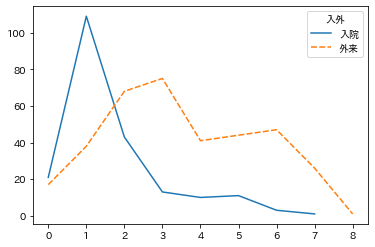

In [39]:
df2 = pd.pivot_table(df,
                     index='hour', columns='入外', values='オーダー番号',
                     aggfunc='count'
                     )
df2.reset_index(inplace=True)
#sns.set_theme(style="darkgrid")
sns.lineplot(df2)

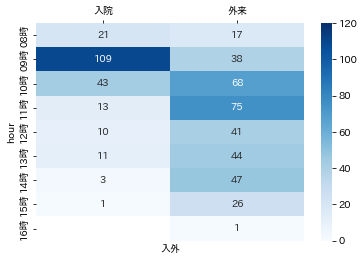

In [40]:
df2.set_index('hour', inplace=True)
plt.figure(figsize=(6, 4))
ax = sns.heatmap(df2, annot=True, fmt='g', cmap='Blues', vmax=120, vmin=0)
ax.xaxis.tick_top()

Text(0.5, 1.0, '時間ごとの化療調製Rp数')

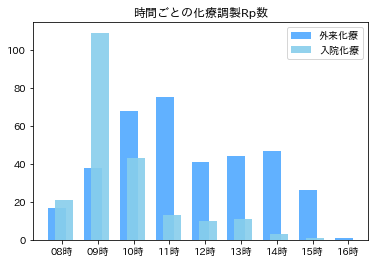

In [41]:
position = np.arange(len(df2.index))
gap = 0.2
# 2つ目の系列のポジション
#print(position+gap)
df2.reset_index(inplace=True)
plt.bar(position, df2['外来'], width=0.5, alpha=0.7, color='dodgerblue', label='外来化療')
plt.bar(position+gap, df2['入院'], width=0.5, alpha=0.9, color='skyblue', label='入院化療')
plt.xticks(position+gap*2/3, df2['hour'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.5, fontsize=10)
plt.title('時間ごとの化療調製Rp数')

Text(0.5, 1.0, '時間ごとの化療調製Rp数')

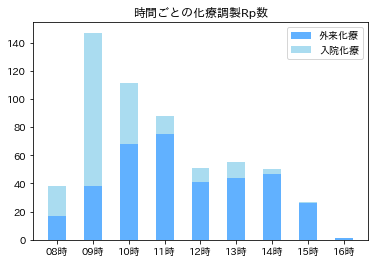

In [42]:
plt.bar(df2['hour'], df2['外来'], width=0.5, alpha=0.7, color='dodgerblue', label='外来化療')
plt.bar(df2['hour'], df2['入院'], width=0.5, alpha=0.7, color='skyblue', label='入院化療', bottom=df2['外来'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.5, fontsize=10)
plt.title('時間ごとの化療調製Rp数')

In [43]:
#for文でスタック　※各要素の数字データ表示が上手くいかない
df2 = pd.pivot_table(dfq,
                     index='hour', columns='入外', values='オーダー番号',
                     aggfunc='count'
                     )
df2.reset_index(inplace=True)
if '外来' not in df2.columns:
    df2['外来'] = 0
fig, ax = plt.subplots()
fig1, ax1 = plt.subplots()
subcategories = ['外来', '入院']
dic_color = {'外来': 'dodgerblue', 
                '入院': 'skyblue'}
bottom = np.zeros(len(df2['hour']))
#積み上げ棒グラフ
for subcategory in subcategories:
    bars = ax.bar(df2['hour'], df2[subcategory], width=0.5, alpha=0.7, 
                    color=dic_color[subcategory], label=subcategory, bottom=bottom
                    )
    bottom += np.array(df2[subcategory])
    ax.bar_label(bars, label_type='edge')
ax.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.5, fontsize=10)
ax.set_title(f'時間ごとの化療調製Rp数  {yyyymmdd} ({wd_dic[weekday]})')
st.pyplot(fig)

NameError: name 'dfq' is not defined

In [44]:
df2.head(2)

入外,hour,入院,外来
0,08時,21.0,17.0
1,09時,109.0,38.0


In [45]:
df.columns

Index(['実施日', '入外', '科名', '病棟', 'オーダー番号', '薬品本数', '薬品コード', '薬品名', '調製開始',
       'stem', 'contain', 'prep_time', '調製者', 'mg', 'hour', 'wd'],
      dtype='object')

In [7]:
df_alt = df[['実施日', '入外', 'オーダー番号', 'hour', 'wd']]
df_alt_m = pd.melt(df_alt, 
                   id_vars=['実施日', 'wd', 'hour', '入外'])
day = '2024-03-08'
dfq = df_alt_m.query(f'実施日 == "{day}"')
dfq.head()

,実施日,wd,hour,入外,variable,value
8113,2024-03-08,Fri,13時,外来,オーダー番号,60040095-1
8132,2024-03-08,Fri,09時,入院,オーダー番号,60031672-1
8142,2024-03-08,Fri,14時,入院,オーダー番号,60028668-1
8153,2024-03-08,Fri,09時,入院,オーダー番号,60025236-1
8182,2024-03-08,Fri,09時,入院,オーダー番号,60019810-1


In [8]:
bars = alt.Chart(dfq).mark_bar(size=25).encode(
    x=alt.X('hour', title='時間', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('count(value)', title='調製件数').stack('zero'),
    color=alt.Color('入外', scale=alt.Scale(domain=['入院', '外来'], range=['skyblue', 'dodgerblue']))
    ).properties(
                width=400,
                height=300,
                title='時間ごとの調製件数（1日）'
                )

text = alt.Chart(dfq).mark_text(dx=0, dy=-5, color='black').encode(
    x=alt.X('hour'),
    y=alt.Y('count(value)').stack('zero'),
    detail='入外',
    text=alt.Text('count(value)', format='.0f')
)

bars + text

alt.LayerChart(...)

In [48]:
df_alt_m.head()

,実施日,wd,hour,入外,variable,value
0,2024-05-07,Tue,08時,外来,オーダー番号,59983940-1
1,2024-05-07,Tue,14時,外来,オーダー番号,60356726-1
2,2024-05-07,Tue,08時,外来,オーダー番号,60502627-1
3,2024-05-08,Wed,08時,外来,オーダー番号,60502631-1
4,2024-05-10,Fri,14時,外来,オーダー番号,60565831-1


In [49]:
#休日で外来が無い場合
day = '2024-05-06'
dfq = df.query(f'実施日 == "{day}"')
df2 = pd.pivot_table(dfq,
                    index='hour', columns='入外', values='オーダー番号',
                    aggfunc='count'
                    )
df2.reset_index(inplace=True)
df2.head()

入外,hour,入院
0,09時,11
1,10時,2


In [50]:
if '外来' not in df2.columns:
    df2['外来'] = 0

Text(0.5, 1.0, '時間ごとの化療調製Rp数(2024-05-06)')

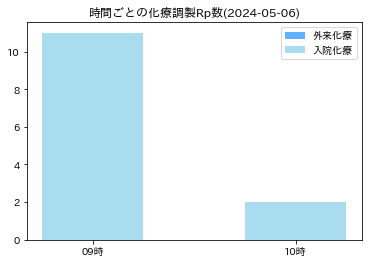

In [51]:
fig, ax = plt.subplots()
ax.bar(df2['hour'], df2['外来'], width=0.5, alpha=0.7, color='dodgerblue', label='外来化療')
ax.bar(df2['hour'], df2['入院'], width=0.5, alpha=0.7, color='skyblue', label='入院化療', bottom=df2['外来'])
ax.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.5, fontsize=10)
ax.set_title(f'時間ごとの化療調製Rp数({day})')

#### 調製件数（複数日データ）

In [52]:
#df.columns
df3 = df.pivot_table(index=['実施日', 'hour'], columns='入外', values='オーダー番号', aggfunc='count')
df3.reset_index(inplace=True)
df3 = pd.melt(df3, id_vars=['実施日', 'hour'], value_vars=['入院', '外来'], var_name='入外', value_name='count')

line = alt.Chart(df3).mark_line().encode(
          x='hour',
          y='mean(count)',
          color='入外',
          tooltip=['hour', 'mean(count)']
          ).properties(
                    width=400,
                    height=300
                    )
band = alt.Chart(df3).mark_errorband(extent='ci').encode(
    x='hour',
    y=alt.Y('count', title='時間あたりの調製件数'),
    color='入外',
)
line + band

alt.LayerChart(...)

#### 曜日別時間ごとの調製件数（平均）

In [53]:
df.head(2)

,実施日,入外,科名,病棟,オーダー番号,薬品本数,薬品コード,薬品名,調製開始,stem,contain,prep_time,調製者,mg,hour,wd
0,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,カイプロリス,40.0,27.733333,szkr,120.0,08時,Tue
1,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,カイプロリス,40.0,26.333333,szkr,100.0,14時,Tue


In [54]:
wd_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df6 = pd.pivot_table(df,
                     index='hour', columns='wd', values='オーダー番号',
                     aggfunc='count'
                     )
df6 = df6[wd_order]
df6

wd,Mon,Tue,Wed,Thu,Fri,Sat,Sun
hour,,,,,,,
08時,NaN,6.0,9.0,11.0,10.0,2.0,NaN
09時,11.0,23.0,31.0,31.0,30.0,12.0,9.0
10時,2.0,20.0,30.0,25.0,22.0,4.0,8.0
11時,NaN,10.0,27.0,23.0,28.0,NaN,NaN
12時,NaN,9.0,18.0,6.0,18.0,NaN,NaN
13時,NaN,10.0,16.0,9.0,20.0,NaN,NaN
14時,NaN,16.0,14.0,10.0,10.0,NaN,NaN
15時,NaN,5.0,7.0,5.0,10.0,NaN,NaN
16時,NaN,NaN,1.0,NaN,NaN,NaN,NaN


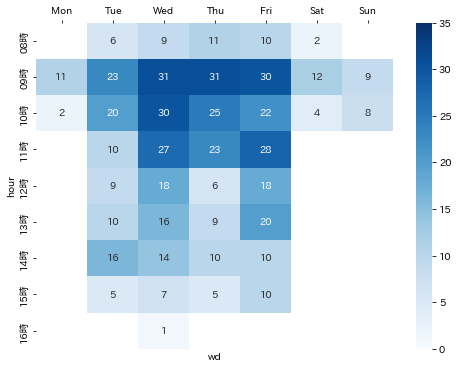

In [55]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(df6, annot=True, fmt='g', cmap='Blues', vmax=35, vmin=0)
ax.xaxis.tick_top()

#### 医薬品ごとの調製時間

In [56]:
df4 = df.dropna(subset='stem') #マスタにない薬剤（Nan）を削除

#選択した薬剤の用量別調製時間を確認
drugs = df4['stem'].unique().tolist()
def create_jointplot(num):
  drug = drugs[num]
  df4q = df4.query('stem == @drug')
  p = sns.jointplot(x="mg", y="prep_time", data=df4q,
                  kind="reg",
                  xlim=(0, df4q['mg'].max()*1.1), ylim=(0, df4q['prep_time'].max()*1.1),
                  color="b",
                  height=5
                  )
  return drug, p

DTX


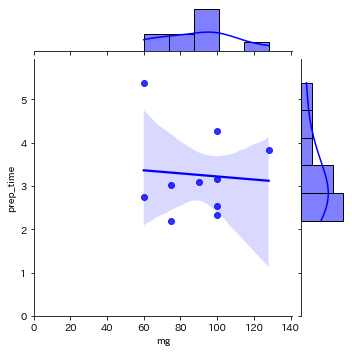

In [57]:
fig = create_jointplot(16)
print(fig[0])
print(fig[1])

<メモ>  
年次と調製時間  
ポインターを合わせればmgが分かるようにする

髄注など複数薬剤が含まれるRpはひろえない

In [58]:
df4q = df4.query('stem == "Aza"')
df4q.head()

,実施日,入外,科名,病棟,オーダー番号,薬品本数,薬品コード,薬品名,調製開始,stem,contain,prep_time,調製者,mg,hour,wd
48,2024-05-07,外来,血液・腫瘍内科,NaN,60329081-1,0.67,I50814,アザシチジン注射用100,2024-05-07 08:52:06,Aza,100.0,2.750000,iszk,67.0,08時,Tue
49,2024-05-08,外来,血液・腫瘍内科,NaN,60329084-1,0.67,I50814,アザシチジン注射用100,2024-05-08 08:52:40,Aza,100.0,3.883333,wtnbk,67.0,08時,Wed
50,2024-05-09,外来,血液・腫瘍内科,NaN,60329089-1,0.67,I50814,アザシチジン注射用100,2024-05-09 09:08:59,Aza,100.0,3.166667,kjm,67.0,09時,Thu
51,2024-05-10,外来,血液・腫瘍内科,NaN,60329092-1,0.67,I50814,アザシチジン注射用100,2024-05-10 09:04:01,Aza,100.0,7.716667,tn,67.0,09時,Fri
52,2024-05-07,外来,血液・腫瘍内科,NaN,60330290-1,1.00,I50814,アザシチジン注射用100,2024-05-07 09:30:21,Aza,100.0,4.050000,szkr,100.0,09時,Tue


In [59]:
df4q = df4q[['stem', '調製者', 'prep_time', 'mg']]  #なぜか余分な列をdropしないとエラーが出る（temestamp...）
df4q.head()

,stem,調製者,prep_time,mg
48,Aza,iszk,2.750000,67.0
49,Aza,wtnbk,3.883333,67.0
50,Aza,kjm,3.166667,67.0
51,Aza,tn,7.716667,67.0
52,Aza,szkr,4.050000,100.0


In [60]:
base = alt.Chart(df4q)
base_bar = base.mark_bar(opacity=0.3, binSpacing=0)

xscale = alt.Scale(domain=(df4q['prep_time'].min()*0.9, df4q['prep_time'].max()*1.1))
yscale = alt.Scale(domain=(df4q['mg'].min()*0.9, df4q['mg'].max()*1.1))

points = base.mark_circle().encode(
    alt.X('prep_time', scale=xscale),
    alt.Y('mg', scale=yscale),
    )
top_hist = (base_bar.encode(
                alt.X('prep_time:Q',
                    bin=alt.Bin(maxbins=20, extent=xscale.domain),
                    stack=None,
                    title="",),
                alt.Y("count()", stack=None, title=""),
                ).properties(height=60)
            )

right_hist = (base_bar.encode(
                alt.Y('mg:Q',
                    bin=alt.Bin(maxbins=20, extent=yscale.domain),
                    stack=None,
                    title="",),
                alt.X("count()", stack=None, title=""),
                ).properties(width=60)
            )

top_hist & (points | right_hist)

alt.VConcatChart(...)

#### 医薬品ごとの調製時間ランキング

In [75]:
df.head()

,実施日,入外,科名,病棟,オーダー番号,薬品本数,薬品コード,薬品名,調製開始,stem,contain,prep_time,調製者,mg,hour,wd
0,2024-05-07,外来,血液・腫瘍内科,NaN,59983940-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:49:42,カイプロリス,40.0,27.733333,szkr,120.0,08時,Tue
1,2024-05-07,外来,血液・腫瘍内科,NaN,60356726-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 14:42:56,カイプロリス,40.0,26.333333,szkr,100.0,14時,Tue
2,2024-05-07,外来,血液・腫瘍内科,NaN,60502627-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-07 08:43:15,カイプロリス,40.0,28.716667,szkr,90.0,08時,Tue
3,2024-05-08,外来,血液・腫瘍内科,NaN,60502631-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-08 08:39:08,カイプロリス,40.0,21.100000,mrsk,90.0,08時,Wed
4,2024-05-10,外来,血液・腫瘍内科,NaN,60565831-1,1.0,I96674,ｶｲﾌﾟﾛﾘｽ点滴静注用40mg Krebs〔要時購入〕,2024-05-10 14:54:58,カイプロリス,40.0,17.566667,ymst,130.0,14時,Fri


In [84]:
for i in range(len(drugs)):
  dfq = df.query(f'stem == "{drugs[i]}"')
  dfqp = dfq.pivot_table(index='調製者', values='prep_time', aggfunc=['count', 'min', 'max', 'mean'])
  dfqp.columns = ['回数', 'min', 'max', '平均']
  dfqp.sort_values('平均', ascending=True, inplace=True)
  print('-------------')
  print(drugs[i])
  print(dfqp.round(2))

-------------
カイプロリス
      回数    min    max     平均
調製者                          
kjm    2  17.23  18.42  17.83
ymst   3  17.57  21.32  19.64
ikd    2  18.27  22.72  20.49
mrsk   1  21.10  21.10  21.10
mtym   1  22.00  22.00  22.00
szkr   4  26.33  28.72  27.55
-------------
ダラキュ―ロ
       回数   min   max    平均
調製者                        
wtnbk   1  1.68  1.68  1.68
mrsk    3  1.68  2.03  1.86
szkr    6  1.65  2.08  1.86
ab      1  2.07  2.07  2.07
ymst    3  2.00  2.63  2.27
kjm     2  2.45  2.45  2.45
ikd     2  2.93  3.12  3.02
-------------
EPI
      回数   min   max    平均
調製者                       
tn     1  5.80  5.80  5.80
ymst   1  8.43  8.43  8.43
-------------
CPA
       回数    min    max     平均
調製者                           
mr      1   9.20   9.20   9.20
mtym    1  12.97  12.97  12.97
wtnbk   4   5.02  24.75  16.40
ngsk    2   6.78  31.08  18.93
szkc    1  19.38  19.38  19.38
ymst    3  13.52  24.50  20.39
mrsk    2  21.77  21.98  21.88
tn      1  27.38  27.38  27.38
------------

#### 医薬品ごと（全体）

In [88]:
df7 = df.pivot_table(index='stem', values='prep_time', aggfunc=['count', 'min', 'max', 'mean'])
df7.columns = ['回数', 'min', 'max', '平均']
df7.sort_values('平均', ascending=True, inplace=True)
df7.tail(10)

,回数,min,max,平均
stem,,,,
アドセトリス,2,6.516667,13.616667,10.066667
カドサイラ,2,7.200000,13.450000,10.325000
トレアキシン,2,6.533333,16.433333,11.483333
MTX,16,1.883333,46.116667,12.393750
ポライビー,5,4.550000,16.500000,12.446667
ダカルバジン,2,14.633333,15.100000,14.866667
CPA,15,5.016667,31.083333,18.487778
nabPTX,18,14.716667,31.883333,21.410185
カイプロリス,13,17.233333,28.716667,22.220513


#### 調製者ごと

- GEM、PTXなど標準医薬品を設定
- 標準医薬品の調製時間ヒストグラムに、各調製者のデータ（線）を付加

In [134]:
df7 = df4.query('stem == "GEM"')
df7 = df7[['prep_time', '調製者', 'mg']]
df7.head()

,prep_time,調製者,mg
170,7.216667,hysbr,1350.0
171,5.083333,szkr,1200.0
172,6.050000,mtym,1600.0
173,4.683333,szkr,1200.0
174,9.033333,wtnbk,1700.0


In [135]:
df7ph = df7.query('調製者 == "kjm"')
mean = df7ph['prep_time'].mean()

In [137]:
len(df7ph)

0

In [136]:
base = alt.Chart(df7).mark_bar().encode(
            x=alt.X('prep_time:Q', 
                    bin=alt.Bin(maxbins=20, extent=xscale.domain),
                    title='調製時間'
                    ),
            y=alt.Y('count()', title='')
            )
rule = alt.Chart().mark_rule(
            #strokeDash=[5, 5], 
            size=1, color='red'
            ).encode(x=alt.datum(mean))
base + rule

alt.LayerChart(...)